### **CS6501 - MACHINE LEARNING AND APPLICATIONS**
#### **NOTEBOOK-7: BER Explainability, and LLM Insights**

**Description:**  
This notebook focuses on **using the trained Voting Regressor model** to predict BER values for a **subset of unseen test data** (20 records) and using SHAP for explainability and a SLM model to suggest imporovements based on the predicted BER

### --- Imports ---

In [27]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import torch
from transformers import pipeline

### --- Load Trained Model ---

In [3]:
with open("./models/BER_PREDICTOR.pkl", "rb") as f:
    voting_model = pickle.load(f)

print("Model loaded successfully!")

Model loaded successfully!


### --- Load and Prepare Dataset ---

In [4]:
# Load the cleaned BER dataset
df = pd.read_csv('../dataset/BERPublicSearch_Cleaned.csv')  
print(f"Dataset shape: {df.shape}")

Dataset shape: (80000, 101)


In [5]:
target_column = 'BerRating'
selected_features = [
    'UValueWall', 'GroundFloorArea(sq m)', 'DeclaredLossFactor', 'UValueRoof', 'UValueFloor',
    'TempAdjustment', 'DeliveredEnergyPumpsFans', 'HSMainSystemEfficiency', 'DistributionLosses',
    'TempFactorMultiplier', 'UValueWindow', 'HeatSystemResponseCat', 'PrimaryEnergyMainSpace',
    'CO2MainSpace', 'FirstFloorArea', 'FirstEnerProdDelivered', 'WHMainSystemEff',
    'DeliveredEnergyMainSpace', 'Year_of_Construction', 'PrimaryEnergyMainWater',
    'PrimaryEnergySecondarySpace', 'PrimaryEnergyPumpsFans', 'NoStoreys', 'PrimaryEnergySupplementaryWater'
]

In [6]:
# Split data into train and test sets
X = df[selected_features]
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

Train set: (64000, 24)
Test set: (16000, 24)


### --- Sample Selection for Explanation ---
We randomly select 20 samples from the test set for prediction and SHAP explanation.

In [7]:
test_df = X_test.copy()
test_df['BerRating'] = y_test
test_df['EnergyRating'] = df.loc[test_df.index, 'EnergyRating']

# Randomly sample 20 test records
sample_20 = test_df.sample(20, random_state=42)

# Extract only feature columns for prediction
X_20 = sample_20[selected_features]

# Predict BER Rating for the 20 samples
sample_20['Predicted_BerRating'] = voting_model.predict(X_20)

In [8]:
sample_20

,UValueWall,GroundFloorArea(sq m),DeclaredLossFactor,UValueRoof,UValueFloor,TempAdjustment,DeliveredEnergyPumpsFans,HSMainSystemEfficiency,DistributionLosses,TempFactorMultiplier,...,DeliveredEnergyMainSpace,Year_of_Construction,PrimaryEnergyMainWater,PrimaryEnergySecondarySpace,PrimaryEnergyPumpsFans,NoStoreys,PrimaryEnergySupplementaryWater,BerRating,EnergyRating,Predicted_BerRating
18664,0.96,46.3900,0.000000,0.00,0.00,0.0,202.4597,91.00,210.1610,1.300000,...,2529.536,1979,3700.270,1015.200,451.500,1,0.000,193.51,C2,186.774953
18545,0.24,334.7805,0.073405,0.23,0.35,0.0,1209.3383,300.00,318.3880,0.952792,...,15120.428,2007,7318.480,12593.810,2377.463,2,0.000,118.50,B2,97.195304
31421,0.55,43.8000,0.022638,0.16,0.47,0.6,878.1490,94.60,199.3890,1.112761,...,6074.382,1998,1634.170,1112.030,1826.550,1,790.970,280.89,D2,269.618056
62168,0.32,78.9100,0.000000,0.13,0.49,0.0,175.0000,73.00,287.1670,1.300000,...,5891.927,1985,5484.400,1836.980,428.750,2,0.000,198.60,C2,198.682687
35123,0.55,77.5600,0.000000,0.26,0.44,0.3,0.0000,100.00,284.0930,1.000000,...,6606.933,2002,5765.950,1526.940,0.000,2,0.000,294.06,D2,285.819033
74248,0.30,280.7200,2.340000,0.58,0.46,0.0,299.0000,97.00,616.7058,0.900000,...,22565.973,1950,6699.320,4245.830,654.810,2,0.000,141.63,B3,153.791943
25541,1.80,88.6700,0.000000,0.73,0.58,0.6,214.0000,77.50,309.0140,1.300000,...,11308.518,1920,7675.010,3721.210,524.300,2,4764.997,357.53,E2,364.915177
17832,1.72,94.3000,0.509948,0.17,0.25,0.0,1039.4110,95.00,0.0000,0.917403,...,13496.909,1950,1237.060,0.000,1818.970,2,0.000,137.90,B3,148.381822
71164,0.16,81.4900,0.873684,0.00,0.00,0.0,455.3170,91.20,265.8560,0.917748,...,220.400,2021,3642.010,0.000,947.060,1,0.000,57.72,A3,48.630967
54536,0.55,106.0200,0.000000,0.20,0.41,0.0,175.0000,87.70,346.4790,0.810000,...,9114.111,1995,4383.177,3374.246,472.500,2,0.000,195.30,C2,182.586669


### --- Classifying based on rule to get BER Rank ---

In [9]:
def ber_band(value):
    if value <= 25: return "A1"
    elif value <= 50: return "A2"
    elif value <= 75: return "A3"
    elif value <= 100: return "B1"
    elif value <= 125: return "B2"
    elif value <= 150: return "B3"
    elif value <= 175: return "C1"
    elif value <= 200: return "C2"
    elif value <= 225: return "C3"
    elif value <= 260: return "D1"
    elif value <= 300: return "D2"
    elif value <= 340: return "E1"
    elif value <= 380: return "E2"
    elif value <= 450: return "F"
    else: return "G"

sample_20['Predicted_EnergyRating'] = sample_20['Predicted_BerRating'].apply(ber_band)

In [11]:
sample_20[['BerRating', 'Predicted_BerRating', 'EnergyRating', 'Predicted_EnergyRating']]

,BerRating,Predicted_BerRating,EnergyRating,Predicted_EnergyRating
18664,193.51,186.774953,C2,C2
18545,118.50,97.195304,B2,B1
31421,280.89,269.618056,D2,D2
62168,198.60,198.682687,C2,C2
35123,294.06,285.819033,D2,D2
74248,141.63,153.791943,B3,C1
25541,357.53,364.915177,E2,E2
17832,137.90,148.381822,B3,B3
71164,57.72,48.630967,A3,A2
54536,195.30,182.586669,C2,C2


### --- SHAP Feature Importance ---
Compute SHAP values for each tree-based model in the ensemble and create a combined explanation for each record.

In [12]:
rf_model = voting_model.named_estimators_['rf']
xgb_model = voting_model.named_estimators_['xgb']
cat_model = voting_model.named_estimators_['cat']

tree_models = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}

In [13]:
shap_values_dict = {}

In [14]:
for name, model in tree_models.items():
    print(f"Computing SHAP for: {name} ...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(sample_20[selected_features])
    shap_values_dict[name] = (explainer, shap_values)

Computing SHAP for: RandomForest ...
Computing SHAP for: XGBoost ...
Computing SHAP for: CatBoost ...


### --- SHAP summary PLOTS ---

--- SHAP Summary Plot for RandomForest ---


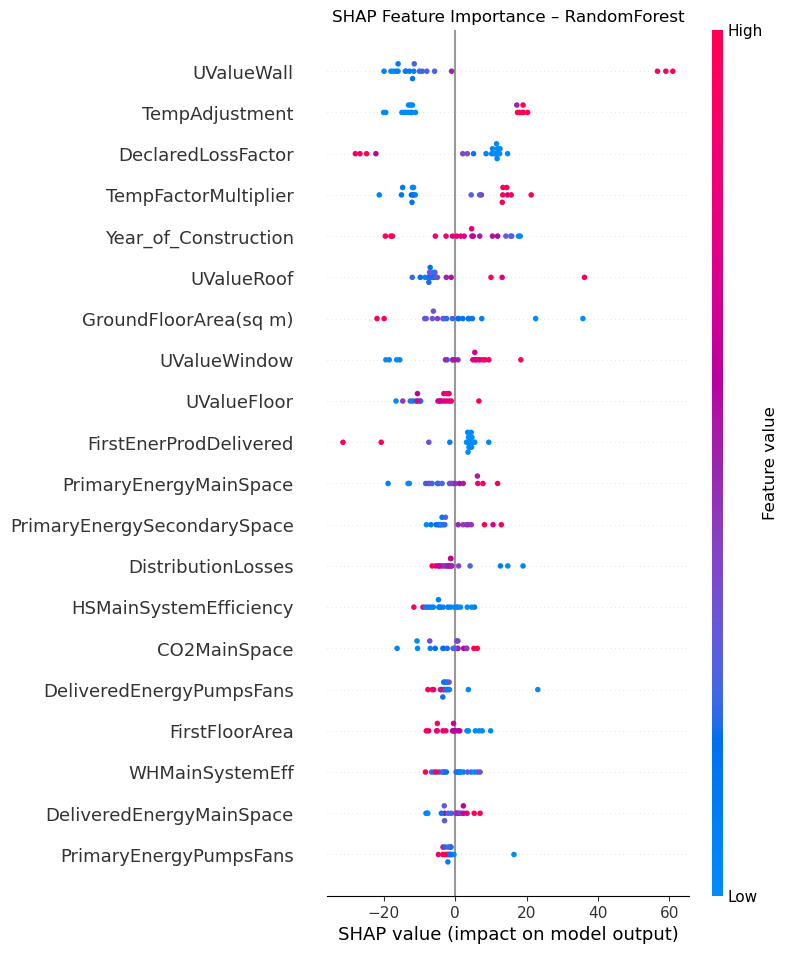

--- SHAP Summary Plot for XGBoost ---


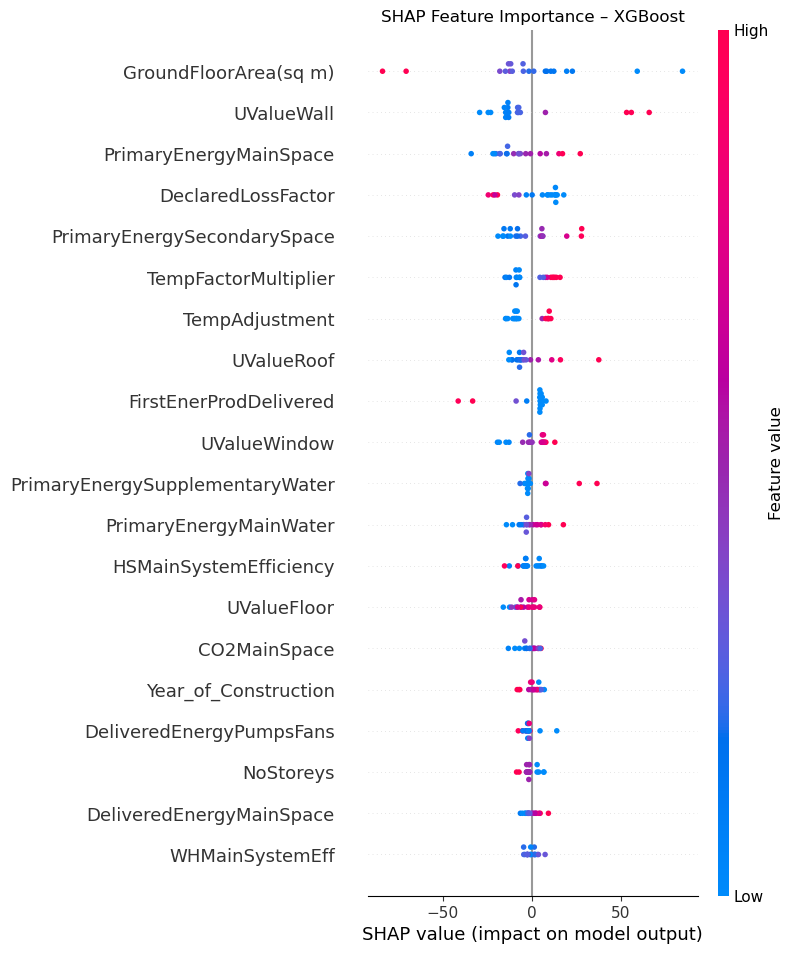

--- SHAP Summary Plot for CatBoost ---


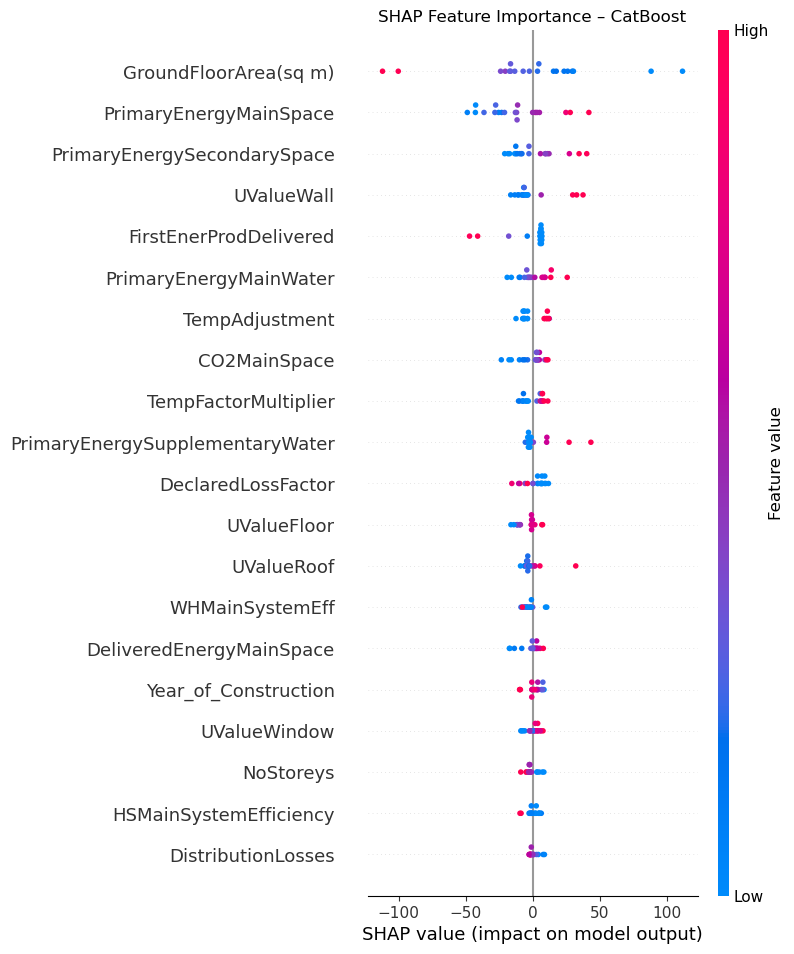

In [15]:
for name, (explainer, shap_values) in shap_values_dict.items():
    print(f"--- SHAP Summary Plot for {name} ---")
    shap.summary_plot(shap_values, sample_20[selected_features], show=False)
    plt.title(f"SHAP Feature Importance – {name}")
    plt.show()

### --- Combine SHAP Values Across Models ---

In [16]:
stacked = np.array([sv for (_, sv) in shap_values_dict.values()])
combined_shap_values = stacked.mean(axis=0)

### --- Function to Extract Top Contributors ---

In [17]:
feature_names = selected_features

def get_top_contributors(shap_row, feature_names, top_k=5):
    shap_series = pd.Series(shap_row, index=feature_names)
    top_positive = shap_series.sort_values(ascending=False).head(top_k)
    top_negative = shap_series.sort_values().head(top_k)
    return top_positive, top_negative

In [45]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    temperature=0.1,
    top_p=0.9
)

'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: 54b88d38-279f-4841-b123-79f609c903ca)')' thrown while requesting HEAD https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct/resolve/main/config.json
Retrying in 1s [Retry 1/5].


KeyboardInterrupt: 

### --- Per-Record Explanation And Suggestions ---
For each sample, we display actual vs predicted BER, energy rating, absolute error, and the top positive and negative contributors to the prediction.

In [38]:
sample_20['LLM_Insight'] = ""

In [39]:
for i in range(len(sample_20)):
    record = sample_20.iloc[i]
    
    actual = record['BerRating']
    predicted = record['Predicted_BerRating']
    energy_actual = record['EnergyRating']
    energy_pred = record['Predicted_EnergyRating']

    pos, neg = get_top_contributors(combined_shap_values[i], feature_names)

    print(f"\n==================== Record {i+1} ====================")
    print(f"Actual BER: {actual}")
    print(f"Predicted BER: {predicted}")
    print(f"Actual Energy Rating: {energy_actual}")
    print(f"Predicted Energy Rating: {energy_pred}")
    print(f"Absolute Error: {abs(actual - predicted):.2f}")

    print("\nTop Positive Factors (Increase BER):")
    for f, val in pos.items():
        print(f"  + {f}: SHAP={val:.4f}, Value={record[f]}")

    print("\nTop Negative Factors (Decrease BER):")
    for f, val in neg.items():
        print(f"  - {f}: SHAP={val:.4f}, Value={record[f]}")

    system_prompt = """
You are an expert energy advisor specialized in Irish homes. 
Your task is to analyze the predicted BER rating for a house, considering the top factors that increase and decrease energy consumption. 

For each house, you should:
-- Summarize the overall energy performance based on the predicted BER.
-- Highlight the strengths—factors that reduce energy consumption and improve BER.
-- Identify weaknesses—factors that increase energy consumption and worsen BER.
-- Provide practical, actionable recommendations to improve the BER rating, suitable for Irish homes.
-- Recommendations should be practically viable
Always base your recommendations on the provided feature values and SHAP impacts.
Keep it short and simple
"""

    llm_prompt = f"""Analyze the following house energy performance:
    
    - Predicted BER: {predicted:.2f} kWh/m²/year ({energy_pred})
    
    Note: **Lower BER values indicate better energy performance.**  
    SHAP impact values indicate how much each feature contributes to the predicted BER:
    - Positive SHAP impact → contributes to higher energy consumption (worsens BER)  
    - Negative SHAP impact → contributes to lower energy consumption (improves BER)
    
    Factors currently contributing to **higher energy consumption** (worsening BER):
    """
    for f, val in pos.items():
        llm_prompt += f"  * {f}: current value = {record[f]}, SHAP impact = {val:.4f} kWh/m²/year\n"
    
    llm_prompt += "\nFactors currently contributing to **lower energy consumption** (improving BER):\n"
    for f, val in neg.items():
        llm_prompt += f"  * {f}: current value = {record[f]}, SHAP impact = {val:.4f} kWh/m²/year\n"
    
    llm_prompt += """
    Please summarize the energy performance of this house, highlight what is already good, 
    and provide **practical recommendations** to reduce energy consumption and improve the BER rating. 
    Focus on realistic retrofit or improvement measures suitable for Irish homes. 
    Do not suggest increasing factors that currently contribute to higher energy consumption.
    """

    # print(llm_prompt)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": llm_prompt}
    ]
    
    print("\nGenerating LLM Insights")
    output = pipe(messages, max_new_tokens=3000, pad_token_id=0)[0]["generated_text"]
    llm_insight = output[-1]['content'] 
    print(llm_insight)
    sample_20.at[record.name, 'LLM_Insight'] = output


==================== Record 1 ====================
Actual BER: 193.51
Predicted BER: 186.77495314304986
Actual Energy Rating: C2
Predicted Energy Rating: C2
Absolute Error: 6.74

Top Positive Factors (Increase BER):
  + GroundFloorArea(sq m): SHAP=56.6584, Value=46.39
  + TempFactorMultiplier: SHAP=16.1369, Value=1.3
  + DeclaredLossFactor: SHAP=9.8247, Value=0.0
  + DistributionLosses: SHAP=9.1621, Value=210.161
  + Year_of_Construction: SHAP=5.1033, Value=1979

Top Negative Factors (Decrease BER):
  - PrimaryEnergyMainSpace: SHAP=-33.8618, Value=2782.49
  - CO2MainSpace: SHAP=-17.6153, Value=513.496
  - UValueFloor: SHAP=-16.2846, Value=0.0
  - TempAdjustment: SHAP=-10.9993, Value=0.0
  - PrimaryEnergySecondarySpace: SHAP=-10.3912, Value=1015.2

Generating LLM Insights


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


**Summary of Energy Performance:**

The predicted BER rating for this house is 186.77 kWh/m²/year (C2). The house has a moderate energy performance, indicating that it is neither extremely efficient nor extremely inefficient.

**Strengths:**

* The house has a relatively high PrimaryEnergyMainSpace value, indicating that it has a significant amount of energy being used for heating.
* The house has a moderate CO2MainSpace value, indicating that it is using a moderate amount of energy for heating.

**Weaknesses:**

* The house has a relatively high DistributionLosses value, indicating that it is losing energy due to inefficiencies in the distribution system.
* The house has a relatively high Year_of_Construction value, indicating that it may be using more energy due to the age of the building.

**Practical Recommendations:**

1. **Improve PrimaryEnergyMainSpace efficiency**:
   - Consider installing a high-efficiency boiler or a heat pump to reduce energy consumption.
   - Consider upgra

In [42]:
def extract_text(llm_output):
    return llm_output[-1]['content']
sample_20['LLM_Insight'] = sample_20['LLM_Insight'].apply(extract_text)

In [43]:
sample_20

,UValueWall,GroundFloorArea(sq m),DeclaredLossFactor,UValueRoof,UValueFloor,TempAdjustment,DeliveredEnergyPumpsFans,HSMainSystemEfficiency,DistributionLosses,TempFactorMultiplier,...,PrimaryEnergyMainWater,PrimaryEnergySecondarySpace,PrimaryEnergyPumpsFans,NoStoreys,PrimaryEnergySupplementaryWater,BerRating,EnergyRating,Predicted_BerRating,Predicted_EnergyRating,LLM_Insight
18664,0.96,46.3900,0.000000,0.00,0.00,0.0,202.4597,91.00,210.1610,1.300000,...,3700.270,1015.200,451.500,1,0.000,193.51,C2,186.774953,C2,**Summary of Energy Performance:**\n\nThe pred...
18545,0.24,334.7805,0.073405,0.23,0.35,0.0,1209.3383,300.00,318.3880,0.952792,...,7318.480,12593.810,2377.463,2,0.000,118.50,B2,97.195304,B1,**Summary of Energy Performance:**\n\n- Predic...
31421,0.55,43.8000,0.022638,0.16,0.47,0.6,878.1490,94.60,199.3890,1.112761,...,1634.170,1112.030,1826.550,1,790.970,280.89,D2,269.618056,D2,**Summary of Energy Performance:**\n\n- Predic...
62168,0.32,78.9100,0.000000,0.13,0.49,0.0,175.0000,73.00,287.1670,1.300000,...,5484.400,1836.980,428.750,2,0.000,198.60,C2,198.682687,C2,**Summary of Energy Performance:**\n\n- Predic...
35123,0.55,77.5600,0.000000,0.26,0.44,0.3,0.0000,100.00,284.0930,1.000000,...,5765.950,1526.940,0.000,2,0.000,294.06,D2,285.819033,D2,**Summary of Energy Performance:**\n\n- Predic...
74248,0.30,280.7200,2.340000,0.58,0.46,0.0,299.0000,97.00,616.7058,0.900000,...,6699.320,4245.830,654.810,2,0.000,141.63,B3,153.791943,C1,**Summary of Energy Performance:**\n\n- Predic...
25541,1.80,88.6700,0.000000,0.73,0.58,0.6,214.0000,77.50,309.0140,1.300000,...,7675.010,3721.210,524.300,2,4764.997,357.53,E2,364.915177,E2,**Summary of Energy Performance:**\n\nThe pred...
17832,1.72,94.3000,0.509948,0.17,0.25,0.0,1039.4110,95.00,0.0000,0.917403,...,1237.060,0.000,1818.970,2,0.000,137.90,B3,148.381822,B3,**Summary of Energy Performance:**\n\n- Predic...
71164,0.16,81.4900,0.873684,0.00,0.00,0.0,455.3170,91.20,265.8560,0.917748,...,3642.010,0.000,947.060,1,0.000,57.72,A3,48.630967,A2,**Summary of Energy Performance:**\n\nThe pred...
54536,0.55,106.0200,0.000000,0.20,0.41,0.0,175.0000,87.70,346.4790,0.810000,...,4383.177,3374.246,472.500,2,0.000,195.30,C2,182.586669,C2,**Summary of Energy Performance:**\n\n- Predic...


In [44]:
sample_20.to_csv("./../dataset/sample_20_with_llm_insights.csv", index=False)

print("Dataset saved as 'sample_20_with_llm_insights.csv'")

Dataset saved as 'sample_20_with_llm_insights.csv'


# BER Prediction Notebook Summary

- **Data and Model:**  
  - Imported the **trained voting regressor** model.  
  - Took a **20-record subset from the test set** to ensure predictions are made on unseen data.  

- **Prediction and Energy Rating:**  
  - Predicted **BER values** (kWh/m²/year) for the 20 houses.  
  - Demonstrated a **rule-based mapping to energy ratings** (A1–G), highlighting that BER is inherently a **regression problem**, not classification, as many previous projects in this dataset treated it.  

- **Explainability with SHAP:**  
  - Applied **SHAP** for each individual model in the voting regressor (RandomForest, XGBoost, CatBoost).  
  - **Combined SHAP values** across models to get a single explanation per house.  
  - Identified **top 5 positive contributors** (increase BER) and **top 5 negative contributors** (reduce BER), giving a **statistical explanation** of why a house has a high or low BER.  

- **LLM Insights:**  
  - Fed the SHAP statistics into a **local Llama-3.2-1B-Instruct** model to generate human-readable insights and practical recommendations.  
  - Current insights are **slightly generic and may hallucinate**, but they provide a starting point for energy retrofit suggestions.  
  - Future improvements could involve using a **larger or API-enabled LLM** for more accurate and structured recommendations.  

